# Title: Marking lane lines

## I. Problem Statement:
  
  
  Detect highway lane lines from a video stream in a variety of conditions, including changing road surfaces, curved roads, and variable lighting. Use OpenCV image analysis techniques to identify lines, including Soble / Canny edge detection, camera calibration and transforms, as well as filters, polynomial fits.
  
## II. Outcome: 
 Autonomous vehicle must follow the lane rules. To enable this code will detect lane departure, curvature etc.
 
## III. Table of contents:
* Description of libraries used.
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
* Future Improvements
* References







### 1. Libraries used:
    1.1 matplotlib
    1.2 numpy
    1.3 cv2
    1.4 moviepy
    1.5 imageio
    1.6 pickle
 


In [1]:
import matplotlib.pyplot as plt

Provides a MATLAB-like plotting framework. This is very convenient for interactive work as mathematical plots can 
be easily done.
This imports the module "matplotlib.pyplot" and binds that to the name "plt".

In [2]:
import matplotlib.image as mpimg

This image module supports basic image loading, rescaling and display operations. This imports the module "matplotlib.image" and binds that to the name "mpimg"

In [3]:
import cv2

OpenCV (Open Source Computer Vision) is a library of programming functions mainly aimed at real-time computer vision.
OpenCV has a modular structure, which means that the package includes several shared or static libraries.

In [4]:
import numpy as np

NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays. It is the short form for numerical python package. 

In [5]:
import pickle

“Pickling” is the process whereby a Python object hierarchy is converted into a byte stream, and “unpickling” is the inverse operation, whereby a byte stream is converted back into an object hierarchy. Pickling (and unpickling) is alternatively known as “serialization”, “marshalling,” or “flattening”, however, to avoid confusion, the terms used here are “pickling” and “unpickling”.

## 2. Calibration

1) Today’s cheap pinhole cameras introduces a lot of   distortion    to images. Two major distortions are radial distortion and tangential distortion.

* Radial distortion: Real cameras use curved lenses to form an image, and light rays often bend a little too much or too little at the edges of these lenses. This creates an effect that distorts the edges of images, so that lines or objects appear more or less curved than they actually are. This is called radial distortion, and it’s the most common type of distortion.


* Tangential distortion: This occurs when a camera’s lens is not aligned perfectly parallel to the imaging plane, where the camera film or sensor is. This makes an image look tilted so that some objects appear farther away or closer than they actually are.



2) Important input data needed for camera calibration is a set of 3D real world points and its corresponding 2D image points. 3D points are called object points and 2D image points are called image points.

* **2D image points** can be easily found from the image. (eg. These image points are locations where two black squares touch each other in chess boards.)

* For obtaining **3D object points** images are taken from a static camera and chess boards are placed at different locations and orientations. So we need to know (X,Y,Z) values. But for simplicity, we can say chess board was kept stationary at XY plane, (so Z=0 always) and camera was moved accordingly. This consideration helps us to find only X,Y values. Now for X,Y values, we can simply pass the points as (0,0), (1,0), (2,0), ... which denotes the location of points. In this case, the results we get will be in the scale of size of chess board square. But if we know the square size, (say 30 mm), and we can pass the values as (0,0),(30,0),(60,0),..., we get the results in mm.



3) This result of chessboard calibration stored into a pickle file. 

In [6]:
with open("camera_calibration_result.p", mode='rb') as f:
    camera_calib = pickle.load(f)

mtx = camera_calib["mtx"] #camera matrix 
dist = camera_calib["dist"] #distortion coefficients

## 3. Birds eye view

1) It is used to warp the image, as if it is seem from above. That is because makes more sense to fit a curve on the lane from this point of view, then unwarp to return to the original view.

2) Here we are considering the camera is mounted in a fixed position, and the relative position of the lanes are always the same.

3) The opencv function warp needs 4 origins and destinations points.
* The origins are like a trapezium containing the lane. The destination is a rectangle. 
* 4 points in the original camera image(origins), and then stretching the image such that the region between the 4 points forms a rectangular section(destination).

<div class="alert alert-block alert-warning">
M = cv2.getPerspectiveTransform(src,dst)
</div>
Returns M which is transformation matrix.

<div class="alert alert-block alert-warning">
warped_image = cv2.warpPerspective(img,M,img_size)
</div>

warped image is top view, which is not as clear as source but clear enough to mark lanes.

<img src = "Images/birds_eye.png">

## 4. Binary Thresholding for finding lane lines:

<img src="Images/Binary Threshold Pipeline .jpg">

### 4.1) Color Selection (In-range binary)

* In previous module region of interest was used to eliminate parts of image other than road. Region was a trapezium, worked well for the sraight roads. For curved road above solution is not optimal.

* We use color and gradient thresholds to filter out what we don’t want. We know some features of the lanes: they are white or yellow. There is a high contrast between road and lanes. And they form an angle: they are not totally vertical or horizontal in image.

* We do a color threshold filter to pick only yellow and white elements,using opencv convert color to HSV space (Hue, Saturation and Value). 

* The HSV dimension is suitable to do this, because it isolates 
  * Color(hue), 
  * Amount of color (saturation) and 
  * Brightness (value).
  
We define the range of yellow independent on the brightness (for example, in shadow or under the sun).

Therefore, by converting images to HSV scale, good color discrimination can be obtained.


In [7]:
def hsv_color_thresh(img, threshLow, threshHigh):
    
    imgHSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    binary_output = np.zeros((img.shape[0], img.shape[1])) #blank image
    
    #compare Hue = imgHSV[:,:,0], Saturation = imgHSV[:,:,1], Value = imgHSV[:,:,2] with threshold values
    binary_output[(imgHSV[:,:,0] >= threshLow[0]) & (imgHSV[:,:,0] <= threshHigh[0]) & (imgHSV[:,:,1] >= threshLow[1])  & (imgHSV[:,:,1] <= threshHigh[1])  & (imgHSV[:,:,2] >= threshLow[2]) & (imgHSV[:,:,2] <= threshHigh[2])] = 1
                 
    return binary_output #Return a binary image of threshold result

Test yellow mask as
<div class="alert alert-block alert-warning">
yellow_low = np.array([0,100,100])

yellow_high = np.array([50,255,255])
</div>
and white mask as
<div class="alert alert-block alert-warning">
white_low = np.array([18,0,180])

white_high = np.array([255,80,255])
</div>
As both the masks are very robust to different lighting conditions because different lighting images of yellow color are generated by changing the brightness channel, while keeping the hue or color channel fixed. Figures below show the effect of applying our yellow mask for different lighting conditions.

Example of color thresholds


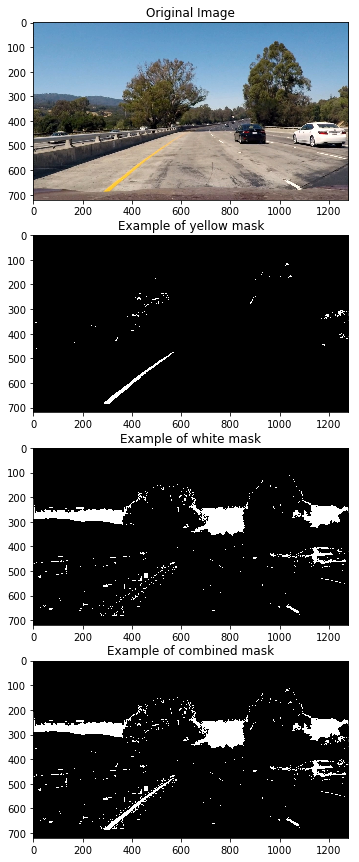

In [8]:
#Example of color thresholds
img = cv2.imread("test_images/test1.jpg")
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Converting BGR read by imread() to RGB

print("Example of color thresholds")

yellow_low = np.array([0,100,100])   #light yellow
yellow_high = np.array([50,255,255]) #darker shade

white_low = np.array([18,0,180])
white_high = np.array([255,80,255])

imgThres_yellow = hsv_color_thresh(imgRGB,yellow_low,yellow_high)
imgThres_white = hsv_color_thresh(imgRGB,white_low,white_high)

imgThres_both =np.zeros_like(imgThres_yellow)
imgThres_both[(imgThres_yellow==1) | (imgThres_white==1)] =1 #adding both masks

plt.figure(figsize=(15,15))

plt.subplot(4,1,1)
plt.title("Original Image")
plt.imshow(imgRGB)

plt.subplot(4,1,2)
plt.title("Example of yellow mask")
plt.imshow(imgThres_yellow,cmap ='gray')


plt.subplot(4,1,3)
plt.title("Example of white mask")
plt.imshow(imgThres_white,cmap ='gray')


plt.subplot(4,1,4)
plt.title("Example of combined mask")
plt.imshow(imgThres_both,cmap ='gray')

plt.show()

### 4.2) Edge Filter (Threshold Binary)
    
4.2.1) Sobel edge detection: 
    
1) The color masks above are good to choose lane markings, if there are no other yellow or white markings on the road. This is not always possible because roads can have writings in white or yellow on them. Therefore to avoid confusion we also used Sobel filters for edge detection. Sobel filters are used in image processing to obtain edges in an image by performing 2-D convolution of the original image and Sobel operator (or filters). 
     
    
2) Sobel filter along x- and y- directions give gradient or change in image’s intensity along x- and y- directions. These intensities can then be thresholded by magnitude and direction to obtain a binary image that is equal to 1 only at edges. We will apply Sobel filters and threshold the magnitude of the gradients in x- and y- directions for S and L channels of HLS image. We chose HLS channel because in previous experimentation, HLS colorspace was found to be most robust for detecting edges.

Note: It's not entirely necessary to convert to 8-bit (range from 0 to 255) but in practice, it can be useful in the event that you've written a function to apply a particular threshold, and you want it to work the same on input images of different scales, like jpg vs. png. You could just as well choose a different standard range of values, like 0 to 1 etc.

In [9]:
def sobel_x(img, sobel_kernel=3,min_thres = 20, max_thres =100):
    
    #Convert to grayscale
    imghsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    #Channels L and S from HLS
    sobelx1 = cv2.Sobel(imghsl[:,:,1], cv2.CV_64F, 1,0, ksize=sobel_kernel) #for L channel
    sobelx2 = cv2.Sobel(imghsl[:,:,2], cv2.CV_64F, 1,0, ksize=sobel_kernel)
    
    #Convert the absolute value image to 8-bit: Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobelx1 = np.uint8(255*sobelx1/ np.max(sobelx1))
    scaled_sobelx2 = np.uint8(255*sobelx2/ np.max(sobelx2))

    #Create a binary mask where magnitude thresholds are met
    binary_outputx1 = np.zeros_like(scaled_sobelx1)
    binary_outputx1[(scaled_sobelx1 >= min_thres) & (scaled_sobelx1 <= max_thres)] = 1

    binary_outputx2 = np.zeros_like(scaled_sobelx2)
    binary_outputx2[(scaled_sobelx2 >= min_thres) & (scaled_sobelx2 <= max_thres)] = 1

    binary_output = np.zeros_like(scaled_sobelx1)
    binary_output[(binary_outputx1 ==1) | (binary_outputx2 ==1)]=1
    #Return this mask as your binary_output image
    return binary_output

Apply a Sobel filter in the X direction to get image edges that match the direction of the lane lines. Module has only the x direction threshold, because some other directional thresholds included a lot of noise.

Examples of Sobel filter


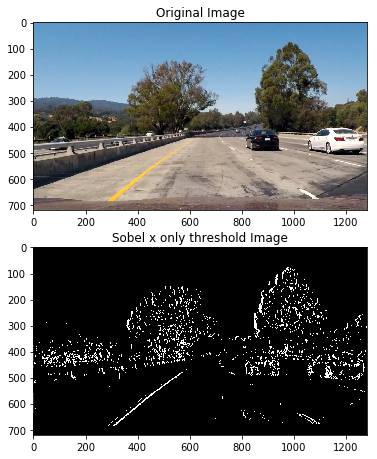

In [10]:
plt.figure(figsize=(10,8))

img = cv2.imread("test_images/test1.jpg")
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Sobel x only
imgThr = sobel_x(imgRGB,9,80,220) #Sobel x

print("Examples of Sobel filter")
plt.figure(figsize=(30,20))

plt.subplot(5,1,1)
plt.title('Original Image')
fig =plt.imshow(imgRGB)


plt.subplot(5,1,2)
plt.title('Sobel x only threshold Image')
fig =plt.imshow(imgThr,cmap = 'gray')

plt.show()




### 4.2.2) Canny edge detection
    1. Canny() parses the pixel values according to their directional derivative (i.e. gradient). Leaving behind the edges or where there is a steep derivative in at least one direction. High and low threshold determine a minimum difference in intensity to establish an edge and to form a contiguous extension of an established  edge, respectively.

    2. Image blurring is achieved by convolving the image with a low-pass filter kernel. It is useful for removing noises. It actually removes high frequency content (eg: noise, edges) from the image. We should specify the width and height of kernel which should be positive and odd. This makes only truly contrasting parts of the picture stand out for next steps. This helps smooth out the overall numbers in the image matrix that defines this picture. The kernel_size is the amount of blur to be applied. The bigger the kernel size blurry the output.

    3. cvtColor() converts image from one color space to another. Here, the image is converted to grayscale. The converted image is assigned to a variable 'gray_image'. 

In [11]:
# Canny edge detector
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size=5):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def run_canny(img, kernel_size=5, low_thresh=50, high_thresh=150):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Apply a Gaussian Blur
    gausImage = gaussian_blur(gray, kernel_size)

    # Run the canny edge detection
    cannyImage = canny(gausImage, low_thresh, high_thresh)

    return cannyImage


#### Testing canny edge detection

Examples of Canny edge detection filter


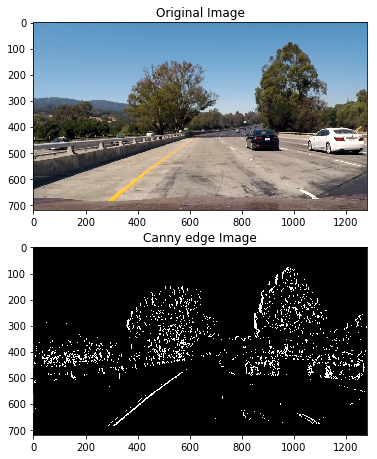

In [12]:
plt.figure(figsize=(10,8))

img = cv2.imread("test_images/test1.jpg")
cannyImage = run_canny(img, kernel_size=5, low_thresh=50, high_thresh=150)

print("Examples of Canny edge detection filter")
plt.figure(figsize=(30,20))

plt.subplot(5,1,1)
plt.title('Original Image')
fig =plt.imshow(imgRGB)


plt.subplot(5,1,2)
plt.title('Canny edge Image')
fig =plt.imshow(imgThr,cmap = 'gray')

plt.show()

## 4.3) Combining the binaries: 

In [13]:
def combineBinary(bin1,bin2):
    combined_binary = np.zeros_like(bin1)
    combined_binary [(bin1 ==1)|(bin2 ==1)]=1
    return combined_binary

#### Tesing on combined output

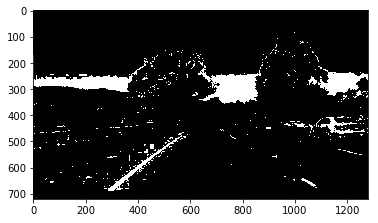

In [14]:
img = cv2.imread("test_images/test1.jpg")
cannyImage = run_canny(img, kernel_size=5, low_thresh=50, high_thresh=150)

imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Converting BGR read by imread() to RGB

yellow_low = np.array([0,100,100])   #light yellow
yellow_high = np.array([50,255,255]) #darker shade

white_low = np.array([18,0,180])
white_high = np.array([255,80,255])

imgThres_yellow = hsv_color_thresh(imgRGB,yellow_low,yellow_high)
imgThres_white = hsv_color_thresh(imgRGB,white_low,white_high)

imgThres_both =np.zeros_like(imgThres_yellow)
imgThres_both[(imgThres_yellow==1) | (imgThres_white==1)] =1 #adding both masks

combined_output = combineBinary(imgThres_both,cannyImage)
plt.imshow(combined_output,cmap='gray')
plt.show()

## 5. Lane detection and Fit

### 5.1 Method 1:

* Second order polynomial $x = ay^2 + by + c$ is used to fit the lane.

* In order to better estimate where the lane is, we use a histogram on the bottom half of image. The lane has most probability to be where there are more vertical points. Doing this, we find the initial point.

<img src="Images/curvefit.png">

* Then we divide the image in windows, and for each left and right window we find the mean of it, re-centering the window. The points inside the windows are stored.
<img src="Images/windows.png">
* We then feed the numpy polyfit function to find the best second order polynomial to represent the lanes.

We can see many edge features that could be due to other artifacts, a prominent one was the horizontal line due to hood of the car. We therefore computed mean value of all the pixels along the x-direction and used a moving average filter to obtain smooth distribution of intensity along the x-direction. We then applied a threshold of 0.05 to identify regions that could contain lane lines. These region boundaries are represented by blue lines.

In [15]:
def fitlines(binary_warped):

    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
   
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
       
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit =[]
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
    
    if len(rightx) == 0:
        right_fit =[]
    else:
        right_fit = np.polyfit(righty, rightx, 2)
    

    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return left_fit, right_fit,out_img


### 5.2 Method 2:

Much faster but less robust. This alleviates much difficulty of the search process by leveraging a previous fit (from a previous video frame, for example) and only searching for lane pixels within a certain range of that fit. The image below demonstrates this - the green shaded area is the range from the previous fit, and the yellow lines and red and blue pixels are from the current image:

<img src="Images/curvefit2.png"/>

In [16]:
def fit_continuous(left_fit, right_fit, binary_warped):
    nonzero = binary_warped.nonzero() #all non zero co-ordinates from warped image
    nonzeroy = np.array(nonzero[0]) #y pixels
    nonzerox = np.array(nonzero[1]) #x pixels
    margin = 100
    
    #use fit coefficients from previous function
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit_updated =[]
    else:
        left_fit_updated = np.polyfit(lefty, leftx, 2)
    
    
    if len(rightx) == 0:
        right_fit_updated =[]
    else:
        right_fit_updated = np.polyfit(righty, rightx, 2)
        
    return  left_fit_updated, right_fit_updated


## 6. Curvature of lanes and vehicle position with respect to center

1) In a given curve, the radius of curvature in some point is the radius of the circle that osculate it i.e same tangent and curvature at this point.
 
   * It will be a indicative to the steering angle of the vehicle. The radius of curvature is given by following formula.

    <img src="Images/Curvature.png">

* We will calculate the radius for both lines, left and right, and the chosen point is the base of vehicle, the bottom of image.

* The image read is in pixels, the real world is in meters. We have to estimate the real world dimension from the photo.

   * meters per pixel in y dimension = 30/720 
   * meters per pixel in x dimension = 3.7/700 
    
2) The offset to the center of lane.
* We assume the camera is mounted exactly in the center of the car. Thus, the difference between the center of the image and the middle point of beginning of lines if the offset (in pixels). 
* This value times conversion factor is the estimate of offset.

<img src="Images/centredistance.png">



In [17]:
#Calc Curvature
def curvature(left_fit, right_fit, binary_warped):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] ) # 0 to height-1 
    y_eval = np.max(ploty) #maximum height
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    #calculate distance from centre (Hardcoded values)
    center = (((left_fit[0]*720**2+left_fit[1]*720+left_fit[2]) +(right_fit[0]*720**2+right_fit[1]*720+right_fit[2]) ) /2 - 640)*xm_per_pix
    
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad, center

### 7. Warp back and display information

Once we know the position of lanes in birds-eye view, we use opencv function polyfill to draw a area in the image. Then, we warp back to original perspective, and merge it to the color image.
We can compose the output image with some other images, to form a diagnostic panel. It is easy done, remembering that an image is just an numpy array. We can resize it, and position this resized image in the
output image.

In [18]:
#Draw line and return image

def drawLine(undist, warped,left_fit, right_fit):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    
    # Fit new polynomials to x,y in world space
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2] 
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (255,215, 0))

    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv_persp, (color_warp.shape[1], color_warp.shape[0])) 

    # Combine the result with the original image

    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return(result, color_warp)

### 8. Checking for errors:
* Check 1: check if left and right fits exists
* Check 2: Calculates the tangent between left and right in two points, and check if it is in a reasonable threshold

In [19]:
def error_check(left_fit, right_fit, minSlope, maxSlope):
    
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    if len(left_fit) ==0 or len(right_fit) == 0:
        status = False
        d0=0
        d1=0
        #Previous fitlines routine returns empty list to them if not finds
    else:
        #Difference of slope
        L_0 = 2*left_fit[0]*460+left_fit[1]
        R_0 = 2*right_fit[0]*460+right_fit[1]
        d0 =  np.abs(L_0-R_0)

        L_1 = 2*left_fit[0]*720+left_fit[1]
        R_1 = 2*right_fit[0]*720+right_fit[1]
        d1 =  np.abs(L_1-R_1)

        
        if d0>= minSlope and d0<= maxSlope and d1>= minSlope and d1<= maxSlope:
            status = True
        else:
            status = False
            
    return(status, d0, d1)
        

## 9. Main function

In [20]:
#Function to process the image
global counter
counter=0
ref_left =np.array([-0.0001,0,400])
ref_right=np.array([-0.0001,0,1000])   
left_fit =np.array([-0.0001,0,400])
right_fit=np.array([-0.0001,0,1000])   
global frame_count
frame_count = 0

src = np.float32([[585, 450], [203, 720], [1127, 720], [695, 450]]) # region of interest
dst = np.float32([[320, 0], [320, 720], [960,720], [960, 0]]) #trial and error

M_persp = cv2.getPerspectiveTransform(src, dst) #bird's eye view
Minv_persp = cv2.getPerspectiveTransform(dst, src) #normal view


def process_image(image):
    #Camera correction
    #Calibration arrays pre-calculated
    img_undist = cv2.undistort(image, mtx, dist, None, mtx)
    global counter
    global frame_count
    #Magnitude Threshold
    
    #Threshold color    
    yellow_low = np.array([0,100,100])
    yellow_high = np.array([50,255,255])
    
    white_low = np.array([18,0,180])
    white_high = np.array([255,80,255])
    global ref_left 
    global ref_right
    global left_fit
    global right_fit

    imgThres_yellow = hsv_color_thresh(img_undist,yellow_low,yellow_high)
    imgThres_white = hsv_color_thresh(img_undist,white_low,white_high)
    imgThr_sobelx = sobel_x(img_undist,9,80,220) #Sobel x

    img_mag_thr =np.zeros_like(imgThres_yellow)
    #combined threshold
    img_mag_thr[(imgThres_yellow==1) | (imgThres_white==1) | (imgThr_sobelx==1)] =1
        
    # Birds-eye
    #Perspective array pre-calculated
    img_size = (img_mag_thr.shape[1], img_mag_thr.shape[0])
    binary_warped = cv2.warpPerspective(img_mag_thr, M_persp, img_size, flags=cv2.INTER_LINEAR)
    
    #Detect lanes and return fit curves
    
    if counter==0:
        left_fit, right_fit,out_imgfit = fitlines(binary_warped) #Method 1
    else:
        left_fit, right_fit = fit_continuous(left_fit, right_fit, binary_warped)  #Method 2
    
    status_error, d0, d1 = error_check(left_fit, right_fit, 0, .55)
    
    #Calc curvature and center

    if status_error  == True:        
        #Save as last reliable fit
        ref_left, ref_right = left_fit, right_fit        
        counter+=1
    else:        #Use the last realible fit
        left_fit, right_fit = ref_left, ref_right
        
    left_curv, right_curv, center_off = curvature(left_fit, right_fit, binary_warped)

    #Warp back to original and merge with image    
    img_merge, img_birds = drawLine(img_undist, binary_warped,left_fit, right_fit)

    #Composition of images to final display
    img_out=np.zeros((576,1280,3), dtype=np.uint8)

    img_out[0:576,0:1024,:] =cv2.resize(img_merge,(1024,576))
    #b) Threshold
    img_out[0:288,1024:1280, 0] =cv2.resize(img_mag_thr*255,(256,288))
    img_out[0:288,1024:1280, 1] =cv2.resize(img_mag_thr*255,(256,288))
    img_out[0:288,1024:1280, 2] =cv2.resize(img_mag_thr*255,(256,288))
    #c)Birds eye view
    img_out[310:576,1024:1280,:] =cv2.resize(img_birds,(256,266))
    
    
    #Write curvature and center in image
    TextL = "Left curv: " + str(int(left_curv)) + " m"
    TextR = "Right curv: " + str(int(right_curv))+ " m"
    TextC = "Center offset: " + str(round( center_off,2)) + "m"
    fontScale=1
    thickness=2
    
    fontFace = cv2.FONT_HERSHEY_SIMPLEX


    cv2.putText(img_out, TextL, (130,40), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, TextR, (130,70), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, TextC, (130,100), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, "Thresh. view", (1070,30), fontFace, .8,(200,200,0), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, "Birds-eye", (1080,305), fontFace, .8,(200,200,0), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out,"Frame Count: %4d" %frame_count,(130,130), fontFace, fontScale,(255,255,255),thickness, lineType = cv2.LINE_AA)
    frame_count +=1
      
    return img_out 
    
        

### 11. Testing on Image

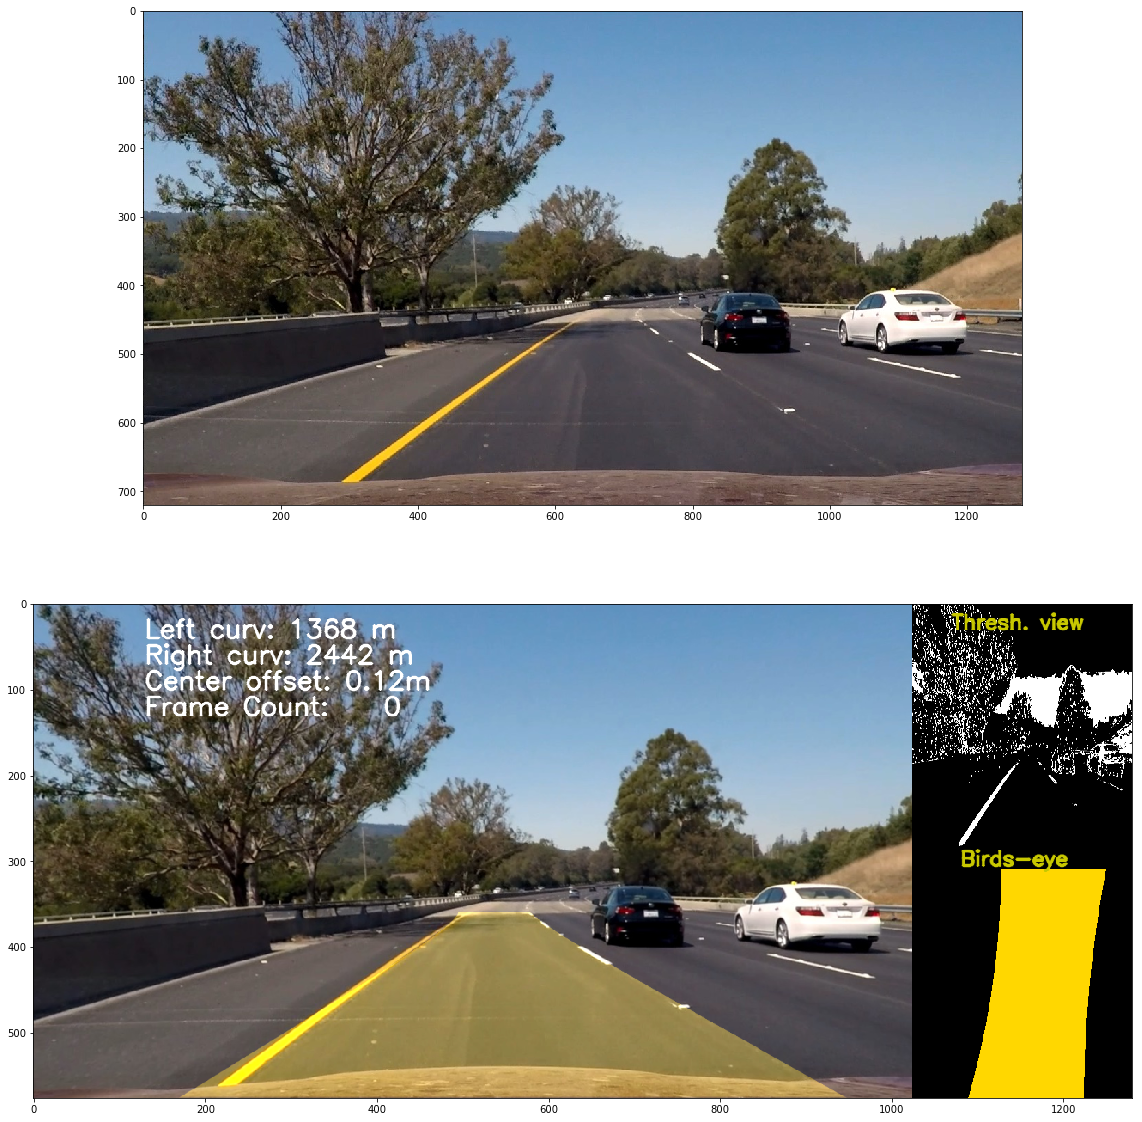

In [21]:
img = cv2.imread("test_images/test6.jpg")

imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img2= process_image(imgRGB)

plt.figure(figsize=(30,20))

plt.subplot(2,1,1)
plt.imshow(imgRGB)

plt.subplot(2,1,2)
plt.imshow(img2)

plt.show()

## 12.Testing on video

In [22]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import moviepy as mve
#Create video file pipeline

output = 'out_test_video.mp4'
clip1 = VideoFileClip("test_video.mp4")
out_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!

%time out_clip.write_videofile(output, audio=False)


[MoviePy] >>>> Building video out_test_video.mp4
[MoviePy] Writing video out_test_video.mp4


100%|█████████▉| 1260/1261 [17:17<00:00,  1.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_test_video.mp4 

CPU times: user 43min 36s, sys: 1min 6s, total: 44min 42s
Wall time: 17min 21s


In [23]:
HTML("""
<video  width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

## 13. Future Imrpovements

1. This project involves lot of hyper-parameters that need to be tuned properly to get the correct results. So use of tools like the varying hyperparameters to check the output was beneficial.

2. The processing of this pipeline on my system is very time consuming, need to check the pipeline on high performance machines with GPU.

3. This project was based on conventional computer vision techniques. Exploring techniques to implement a solution to this problem using techniques from machine learning

## 14 . References:


1. docs.opencv.org
2. OpenCV-Python Tutorials Documentation Release 1 by Alexander Mordvintsev & Abid K
3. matplotlib.org
4. numpy.org
5. zulko.github.io/moviepy/
6. https://pydata.org/berlin2017/schedule/presentation/51/
7. www.intmath.com/applications-differentiation/8-radius-curvature.php
7. http://docs.opencv.org/3.1.0/dc/da5/tutorial_py_drawing_functions.html
8. http://docs.opencv.org/3.3.0/d4/d86/group__imgproc__filter.html#gaabe8c836e97159a9193fb0b11ac52cf1

8. http://docs.opencv.org/3.3.0/d4/d13/tutorial_py_filtering.html

9. http://www.pyimagesearch.com/2016/07/25/convolutions-with-opencv-and-python/

10. https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html

11. https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html

12. https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_table_of_contents_imgproc/py_table_of_contents_imgproc.html

13. https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_core/py_basic_ops/py_basic_ops.html
